# REDES NEURONALES PROFUNDAS
Utilice el conjunto de datos Fashion-MNIST para construir un clasificador convolucional de imágenes de productos. Para la construcción del modelo utilice los dos esquemas que se describen a continuación y compare los resultados:

1. Entrenar de un Autocodificador convolucional multicapa.
2. Extraer la reducción de la dimensionalidad que el Autocodificador construye en el entrenamiento.

Para los puntos 2) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## OBJETIVO
Aplicar el proceso de aprendizaje a partir de datos para resolver problemas de clasificación utilizando redes neuronales convolucionales profundas sobre la herramienta Keras.

## DATOS
Incluidos en Keras.
También, existe otra fuente equivalente que se consigue en el siguiente URL https://www.kaggle.com/zalando-research/fashionmnist donde hay un resumen de estos datos en el archivo CVS y XLSX.

la clasificación para el aprendizaje supervisado es:

    Label 	Class
    0 	 	T-shirt/top
    1 	 	Trouser
    2 	 	Pullover
    3 	 	Dress
    4 	 	Coat
    5 	 	Sandal
    6 	 	Shirt
    7 	 	Sneaker
    8 	 	Bag
    9 	 	Ankle boot

**Importante: Lea los comentarios y apuntes del Notebook para tener claridad de los pasos.**
### Consideraciones
- Utilice sólo los conjuntos de datos indicado.
- El frameworks a utilizar es TensorFlow, Keras con Jupyter Notebbooks.

### Enlaces de interés
- documentación Keras, URL: https://keras.io/models/sequential/
- documentación TensorFlow, URL: https://www.tensorflow.org/versions
- Tutorial CNN basico, URL: https://www.kaggle.com/nhlr21/deep-keras-cnn-tutorial/notebook


## Importando Librerias

In [3]:
# importando dependencias de trabajo
# importando librerias basicas
import os
import sys
import re
import gc

# importando modulos de analisis de datos, ML y graficas
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import OrderedDict
from collections import Counter

# importando dependencias para tensorflow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# importando para sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# importando para keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed

## Funciones Utiles

In [4]:
# funcion que recibe una lista numpy y recupera la forma de cada elemento, devuelve una lista con formas
def get_shape(data):
    # respuesta de la funcion
    ans = list()

    for d in data:
        sp = d.shape
        ans.append(sp)
    return ans

In [5]:
# funcion que transforma el entero de la clase a la palabra de la etiqueta, devuelve una lista de etiquetas
def class2label(data, labels):
    # respuesta de la funcion
    ans = list()

    for d in data:
        d = int(d)
        l = str(labels[d])
        ans.append(l)
    return ans

In [6]:
# funcion que estandariza los datos en numpy de acuerdo a un valor min & max, devuelve un arreglo np flotante
def std_data(data, minv, maxv):
    rangev = maxv - minv
    ans = data.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

## Cargar y Preparar los Datos

Los pasos de esta seccion son:

1. Leer los datos desde MNIST.
2. Formatear los datos para que los acepte el DataFrame de Pandas.
2. Crear el DataFrame de Pandas con un esquema propio.
2. Formatear los datos MNIST para pobrar el DataFrame de pandas.
3. Revisar que todo este como deberia estar.

In [7]:
# lista de nombres de las clasificaciones
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
# se carga el archivo de datos de trabajo por medio de Keras
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [9]:
# nombres de columnas para el dataframe de pandas
col_names = ["img_data", "img_shape", "class", "label", "std_img_data", "cat_labels"]#, "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
# creando dataframe con columnas
fashion_df = pd.DataFrame(columns=col_names)

In [10]:
# integrando datos de mnist
img_data = np.concatenate((x_train, x_test), axis = 0)
class_data = np.concatenate((y_train, y_test), axis = 0)
# recuperando forma de imagenes
img_shape = get_shape(img_data)
# recuperando etiquetas de las clases
labels = class2label(class_data, label_names)
# estandarizar los datos de la imagen
std_img_data = std_data(img_data, 0, 255)
# categorizando las clases a aprender
cat_labels = to_categorical(class_data, len(label_names))

In [11]:
# cambio de formato para utilizar el dataframe
img_data = img_data.tolist()
std_img_data = std_img_data.tolist()
cat_labels = cat_labels.tolist()

In [12]:
# definir arreglo basico de datos
data_list = (img_data, img_shape, class_data, labels, std_img_data, cat_labels)

In [13]:
# poblamdo las columnas del dataframe
for col, data in zip(col_names, data_list):
    fashion_df[col] = data

In [14]:
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_data      70000 non-null  object
 1   img_shape     70000 non-null  object
 2   class         70000 non-null  uint8 
 3   label         70000 non-null  object
 4   std_img_data  70000 non-null  object
 5   cat_labels    70000 non-null  object
dtypes: object(5), uint8(1)
memory usage: 2.7+ MB


In [15]:
fashion_df

,img_data,img_shape,class,label,std_img_data,cat_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",9,Ankle boot,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, ...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156885936856...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64...","(28, 28)",3,Dress,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",0,T-shirt/top,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
69995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(28, 28)",9,Ankle boot,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
69996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 52, 98, 94, 8...","(28, 28)",1,Trouser,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
69997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 6...","(28, 28)",8,Bag,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
69998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 137, 1...","(28, 28)",1,Trouser,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
# libero memoria
gc.collect()

15

## Preprocesar los Datos

Los pasos de esta seccion son:

1. Revisar que los datos esten bien.
2. Elegir la caracteristicas o propiedades de aprendizaje.
3. Elegir la variable objetivo del aprendizaje.
4. Dividir la conjunto de datos entre las poblaciones de entrenamiento y pruebas.
5. Formatear los datos de aprendizaje y objetivo acorde a la red neuronal.

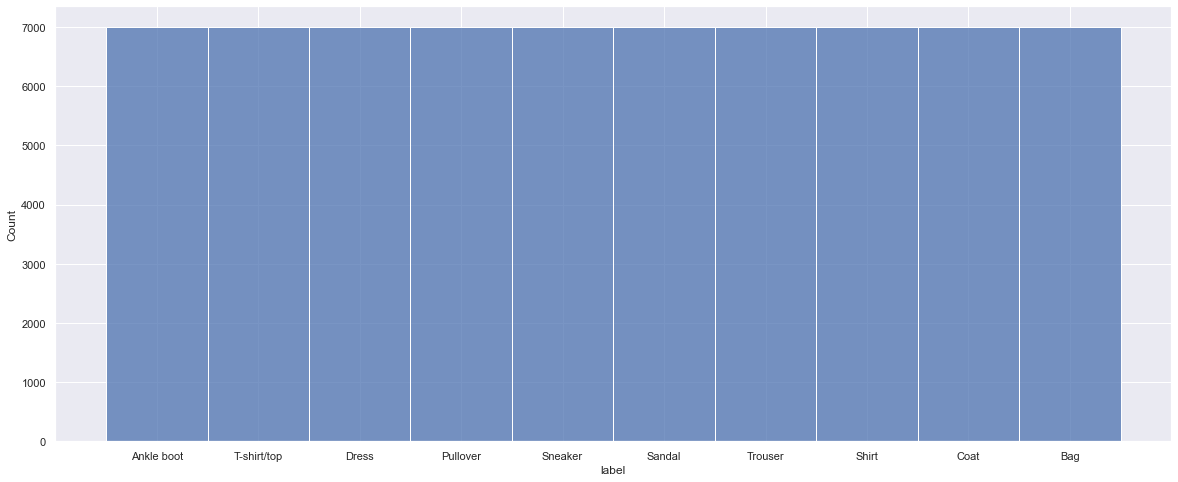

In [17]:
# cchequeo la distribucion de datos
sns.set()
plt.figure(figsize=(20, 8))
sns.histplot(fashion_df[col_names[3]])
plt.show()

In [18]:
# seleccionando caracteristicas de aprendizaje y variables objetivo
# recuperando la forma de las imagenes basado en el primer elemento de la lista

# recuperando los valores y ajustando el tensor para la CNN
A = fashion_df[col_names[4]]
# recuperando los valores de la cateogoria
b = fashion_df[col_names[5]].values

# fortateo de datos numpy
X = np.array([np.array(i, dtype="object") for i in A], dtype="object")
y = np.array([np.array(j, dtype="object") for j in b], dtype="object")

print(X.shape)
# forma basica general de las imagenes
imgsh = X[0].shape
# ajuste de forma para el modelo CNN
X = X.reshape(fashion_df.shape[0], imgsh[0], imgsh[1], 1)
print(X.shape)

(70000, 28, 28)
(70000, 28, 28, 1)


In [19]:
# semilla para el random
rseed = 42

# en tamanho de la muestra para pruebas esta entre 0.2 y 0.3
train_pop = 0.8
test_pop = 1.0 - train_pop

In [20]:
# distribuir los datos entre entrenamiento vs. pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_pop, random_state = rseed)

In [21]:
# formateo para keras y tensorflow
X_train = tf.convert_to_tensor(X_train, dtype="float64")
y_train = tf.convert_to_tensor(y_train, dtype="float64")
X_test = tf.convert_to_tensor(X_test, dtype="float64")
y_test = tf.convert_to_tensor(y_test, dtype="float64")

## Definir Modelo CNN

Los pasos de esta seccion son:

1. Definir las variables topologicas de la red neuronal.
2. Definir los parametros de optimizacion y aprendizaje del modelo.
3. Definir la topologia (capas) del modelo.
4. Definir las condiciones de entrenamiento para el modelo.

In [22]:
# defino parametros necesarios para el modelo Autoencoder
# parametros para las capas
mid_neurons = 16*16
filters = 16
outn = len(label_names)
ksize = (3,3)
psize = (2,2)
act = "relu"
out = "sigmoid"
pad = "same"
ldrop = 0.2

# forma del kernel de entrada y de las capas intermedias
inshape = X[0].shape

# parametros de optimizacion del modelo
l = "categorical_crossentropy"
opti = "adam"
met = ["accuracy"]

# parametros de operacion/aprendizaje del modelo
ver = 1
epo = 50
bs = 32

In [23]:
# definicion de las capas para el Autoencoder
layers = (
    # capa de entrada
    Input(shape = inshape, name = "LayIn"),
    # capa convolucional intermedia con regularizacion
    Conv2D(filters, ksize, activation = act, padding = pad, name = "EnConv1"),
    MaxPooling2D(psize, padding = pad, name = "EnPool1"),
    # BatchNormalization(name = "EnNorm1"),
    Dropout(ldrop, name = "EnDrop1"),

    # capa convolucional intermedia con regularizacion
    Conv2D(int(filters)/2, ksize, activation=act, padding = pad, name = "EnConv2"),
    MaxPooling2D(psize, padding = pad, name = "EnPool2"),
    # BatchNormalization(name = "EnNorm2"),
    # Dropout(ldrop, name = "EnDrop2"),
    
    # capa intermedia de 2D a 1D
    Flatten(name = "LayFlat"),
    # # # capa intermedia densamente poblada con regularizacion
    Dense(mid_neurons, activation = act, name = "DenseMid"),
    Dropout(ldrop, name = "MidDrop"),
    # # # capa intermedia de 1D a 2D
    
    # capa densamente poblada para clasificar los datos 
    Dense(int(mid_neurons)/2, activation = act, name = "DenseClass1"),
    Dropout(ldrop, name = "ClsDrop1"),

    # capa densamente poblada para clasificar los datos 
    Dense(int(mid_neurons)/4, activation = act, name = "DenseClass2"),
    Dropout(ldrop, name = "ClsDrop2"),

    # capa de salida
    Dense(outn, activation=out, name = "LayOut")
)

In [24]:
# definiendo el modelo CNN en Keras
cnn_model = Sequential(layers)
cnn_model.model_name = "DCNN Classifier"

In [25]:
# compilando las condiciones de optimizacion y ajuste del Modelo CNN
cnn_model.compile(loss = l, optimizer = opti, metrics = met)

In [26]:
# resumen de la topologia del modelo
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EnConv1 (Conv2D)             (None, 28, 28, 16)        160       
_________________________________________________________________
EnPool1 (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
EnDrop1 (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
EnConv2 (Conv2D)             (None, 14, 14, 8)         1160      
_________________________________________________________________
EnPool2 (MaxPooling2D)       (None, 7, 7, 8)           0         
_________________________________________________________________
LayFlat (Flatten)            (None, 392)               0         
_________________________________________________________________
DenseMid (Dense)             (None, 256)               1

In [27]:
# condiciones de parada temprana
cnn_earlystop_acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.001, patience = 7, verbose = ver, mode = "max", restore_best_weights = True)

## Entrenar Modelo

Los pasos de esta seccion son:

1. Entrenar el modelo con el conjunto de entrenamineto.

In [28]:
# ajustando el modelo MLP Keras
cnn_log = cnn_model.fit(
    x = X_train,#np.array(X_trainB), 
    y = y_train,#to_categorical(np.array(y_trainB), categories), 
    batch_size = bs,
    epochs = epo, 
    verbose = ver,
    callbacks = [cnn_earlystop_acc],
    workers = 8,
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (X_test, y_test)
)

Epoch 1/50
1750/1750 [==============================] - 15s 8ms/step - loss: 0.8158 - accuracy: 0.6965 - val_loss: 0.3490 - val_accuracy: 0.8742
Epoch 2/50
1750/1750 [==============================] - 14s 8ms/step - loss: 0.3981 - accuracy: 0.8567 - val_loss: 0.3134 - val_accuracy: 0.8846
Epoch 3/50
1750/1750 [==============================] - 15s 8ms/step - loss: 0.3447 - accuracy: 0.8730 - val_loss: 0.2923 - val_accuracy: 0.8929
Epoch 4/50
1750/1750 [==============================] - 15s 9ms/step - loss: 0.3173 - accuracy: 0.8850 - val_loss: 0.2791 - val_accuracy: 0.8999
Epoch 5/50
1750/1750 [==============================] - 17s 10ms/step - loss: 0.3013 - accuracy: 0.8883 - val_loss: 0.2662 - val_accuracy: 0.9047
Epoch 6/50
1750/1750 [==============================] - 21s 12ms/step - loss: 0.2853 - accuracy: 0.8964 - val_loss: 0.2669 - val_accuracy: 0.9052
Epoch 7/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.2722 - accuracy: 0.9014 - val_loss: 0.2604 - val

## Probar Modelo

Los pasos de esta seccion son:

1. Probar el modelo con el conjunto de pruebas.
2. Evaluar globalmente los resultados.
3. Guardar el modelo entrenado.

In [29]:
cnn_eval = cnn_model.evaluate(x = X_test, y = y_test)

438/438 [==============================] - 1s 2ms/step - loss: 0.2433 - accuracy: 0.9184


In [30]:
# resultados generales
print("Perdida promedio: ", cnn_eval[0])
print("Precision promedio: ", cnn_eval[1])

Perdida promedio:  0.24334126710891724
Precision promedio:  0.9184285998344421


In [31]:
# pruebas sobre el modelo
cnn_predictions = cnn_model.predict(X_test, verbose = ver)
print(cnn_predictions.shape)

438/438 [==============================] - 1s 2ms/step
(14000, 10)


In [32]:
# guardar el modelo entrenado
wdir = os.getcwd()
folder_models = "Models"
model_fname = "hdig_cnn_classifier"
model_fpn = os.path.join(folder_models, model_fname)
print("El modelo entrenado esta en:", model_fpn)
cnn_model.save(model_fpn)
# tf.keras.models.save_model(cnn_autoencoder, model_fpn)

El modelo entrenado esta en: Models\hdig_cnn_classifier
INFO:tensorflow:Assets written to: Models\hdig_cnn_classifier\assets


## Mostrar Resultados

Los pasos de esta sección son:

1. Mostrar las curvas de aprendizaje.
2. Mostrar la Matriz de confusión del Clasificador.
3. Mostrar la clasificación del modelo.
4. Mostrar la abstracción del Clasificador.

In [33]:
# ajuste de las predicciones para ver el reporte de matrix de confusion
cnn_count = np.array(cnn_predictions).argmax(axis=1)
y_count = np.array(y_test).argmax(axis=1)
print(cnn_count.shape)
print(y_count.shape)

(14000,)
(14000,)


In [34]:
# preparando informe de la matriz de confusion
cnn_counter = Counter(cnn_count)
cnn_matrix = confusion_matrix(y_count, cnn_count)
cnn_report = classification_report(y_count, cnn_count)

In [35]:
# Informe por consola de las pruebas para el clasificador
print("----- Reporte de Pruebas para el clasificador CNN -----")
print("--- Conteo ---\n", cnn_counter)
print("--- Matriz de Confusion ---\n", cnn_matrix)
print("--- Reporte de Pruebas: ---")
print(cnn_report)
print("--- Puntaje General---\n")
print(" - Perdida: ", cnn_eval[0])
print(" - Precision: ", cnn_eval[1])

----- Reporte de Pruebas para el clasificador CNN -----
--- Conteo ---
 Counter({3: 1539, 5: 1462, 9: 1412, 0: 1408, 4: 1396, 1: 1394, 7: 1374, 2: 1350, 8: 1343, 6: 1322})
--- Matriz de Confusion ---
 [[1216    3   20   26    3    0  117    0    9    0]
 [   2 1381    0   15    2    0    1    0    0    1]
 [  16    0 1201   17  103    0   70    0    0    0]
 [  16    5    3 1383   18    0   23    0    1    0]
 [   0    2   48   50 1182    0   70    0    5    0]
 [   0    0    0    0    0 1433    0    9    0    7]
 [ 157    2   75   44   87    0 1037    0    5    0]
 [   0    0    0    0    0   21    0 1318    2   18]
 [   1    1    3    4    1    4    4    3 1321    0]
 [   0    0    0    0    0    4    0   44    0 1386]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1394
           1       0.99      0.99      0.99      1402
           2       0.89      0.85      0.87      1407
           3       0.90

In [36]:
# despliegue grafico de la matriz de confusion
# dataframe para graficar
confusion_df = pd.DataFrame(data = cnn_matrix, columns=label_names,index=label_names)

# creando el reporte para graficar
cnn_report = classification_report(y_count, cnn_count, output_dict = True)
# dataframe del repodrte
report_df = pd.DataFrame(data = cnn_report)

# dataframe para desplegar el puntaje de las clases
cols = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
idx = ["precision", "recall", "f1-score"]
class_report = pd.DataFrame(report_df[cols], index = idx)
class_report = pd.DataFrame(class_report.values, columns = label_names ,index = idx)
class_report = class_report.T

# dataframe para desplegar el reporte global
cols = ["accuracy", "macro avg", "weighted avg"]
macro_report = pd.DataFrame(report_df[cols], index = idx)
macro_report = macro_report.T

In [37]:
report_df

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.863636,0.990674,0.889630,0.898635,0.846705,0.980164,0.784418,0.959243,0.983619,0.981586,0.918429,0.917831,0.917914
recall,0.872310,0.985021,0.853589,0.954451,0.871039,0.988958,0.737029,0.969831,0.984352,0.966527,0.918429,0.918311,0.918429
f1-score,0.867951,0.987840,0.871237,0.925703,0.858700,0.984541,0.759985,0.964508,0.983985,0.973999,0.918429,0.917845,0.917942
support,1394.000000,1402.000000,1407.000000,1449.000000,1357.000000,1449.000000,1407.000000,1359.000000,1342.000000,1434.000000,0.918429,14000.000000,14000.000000


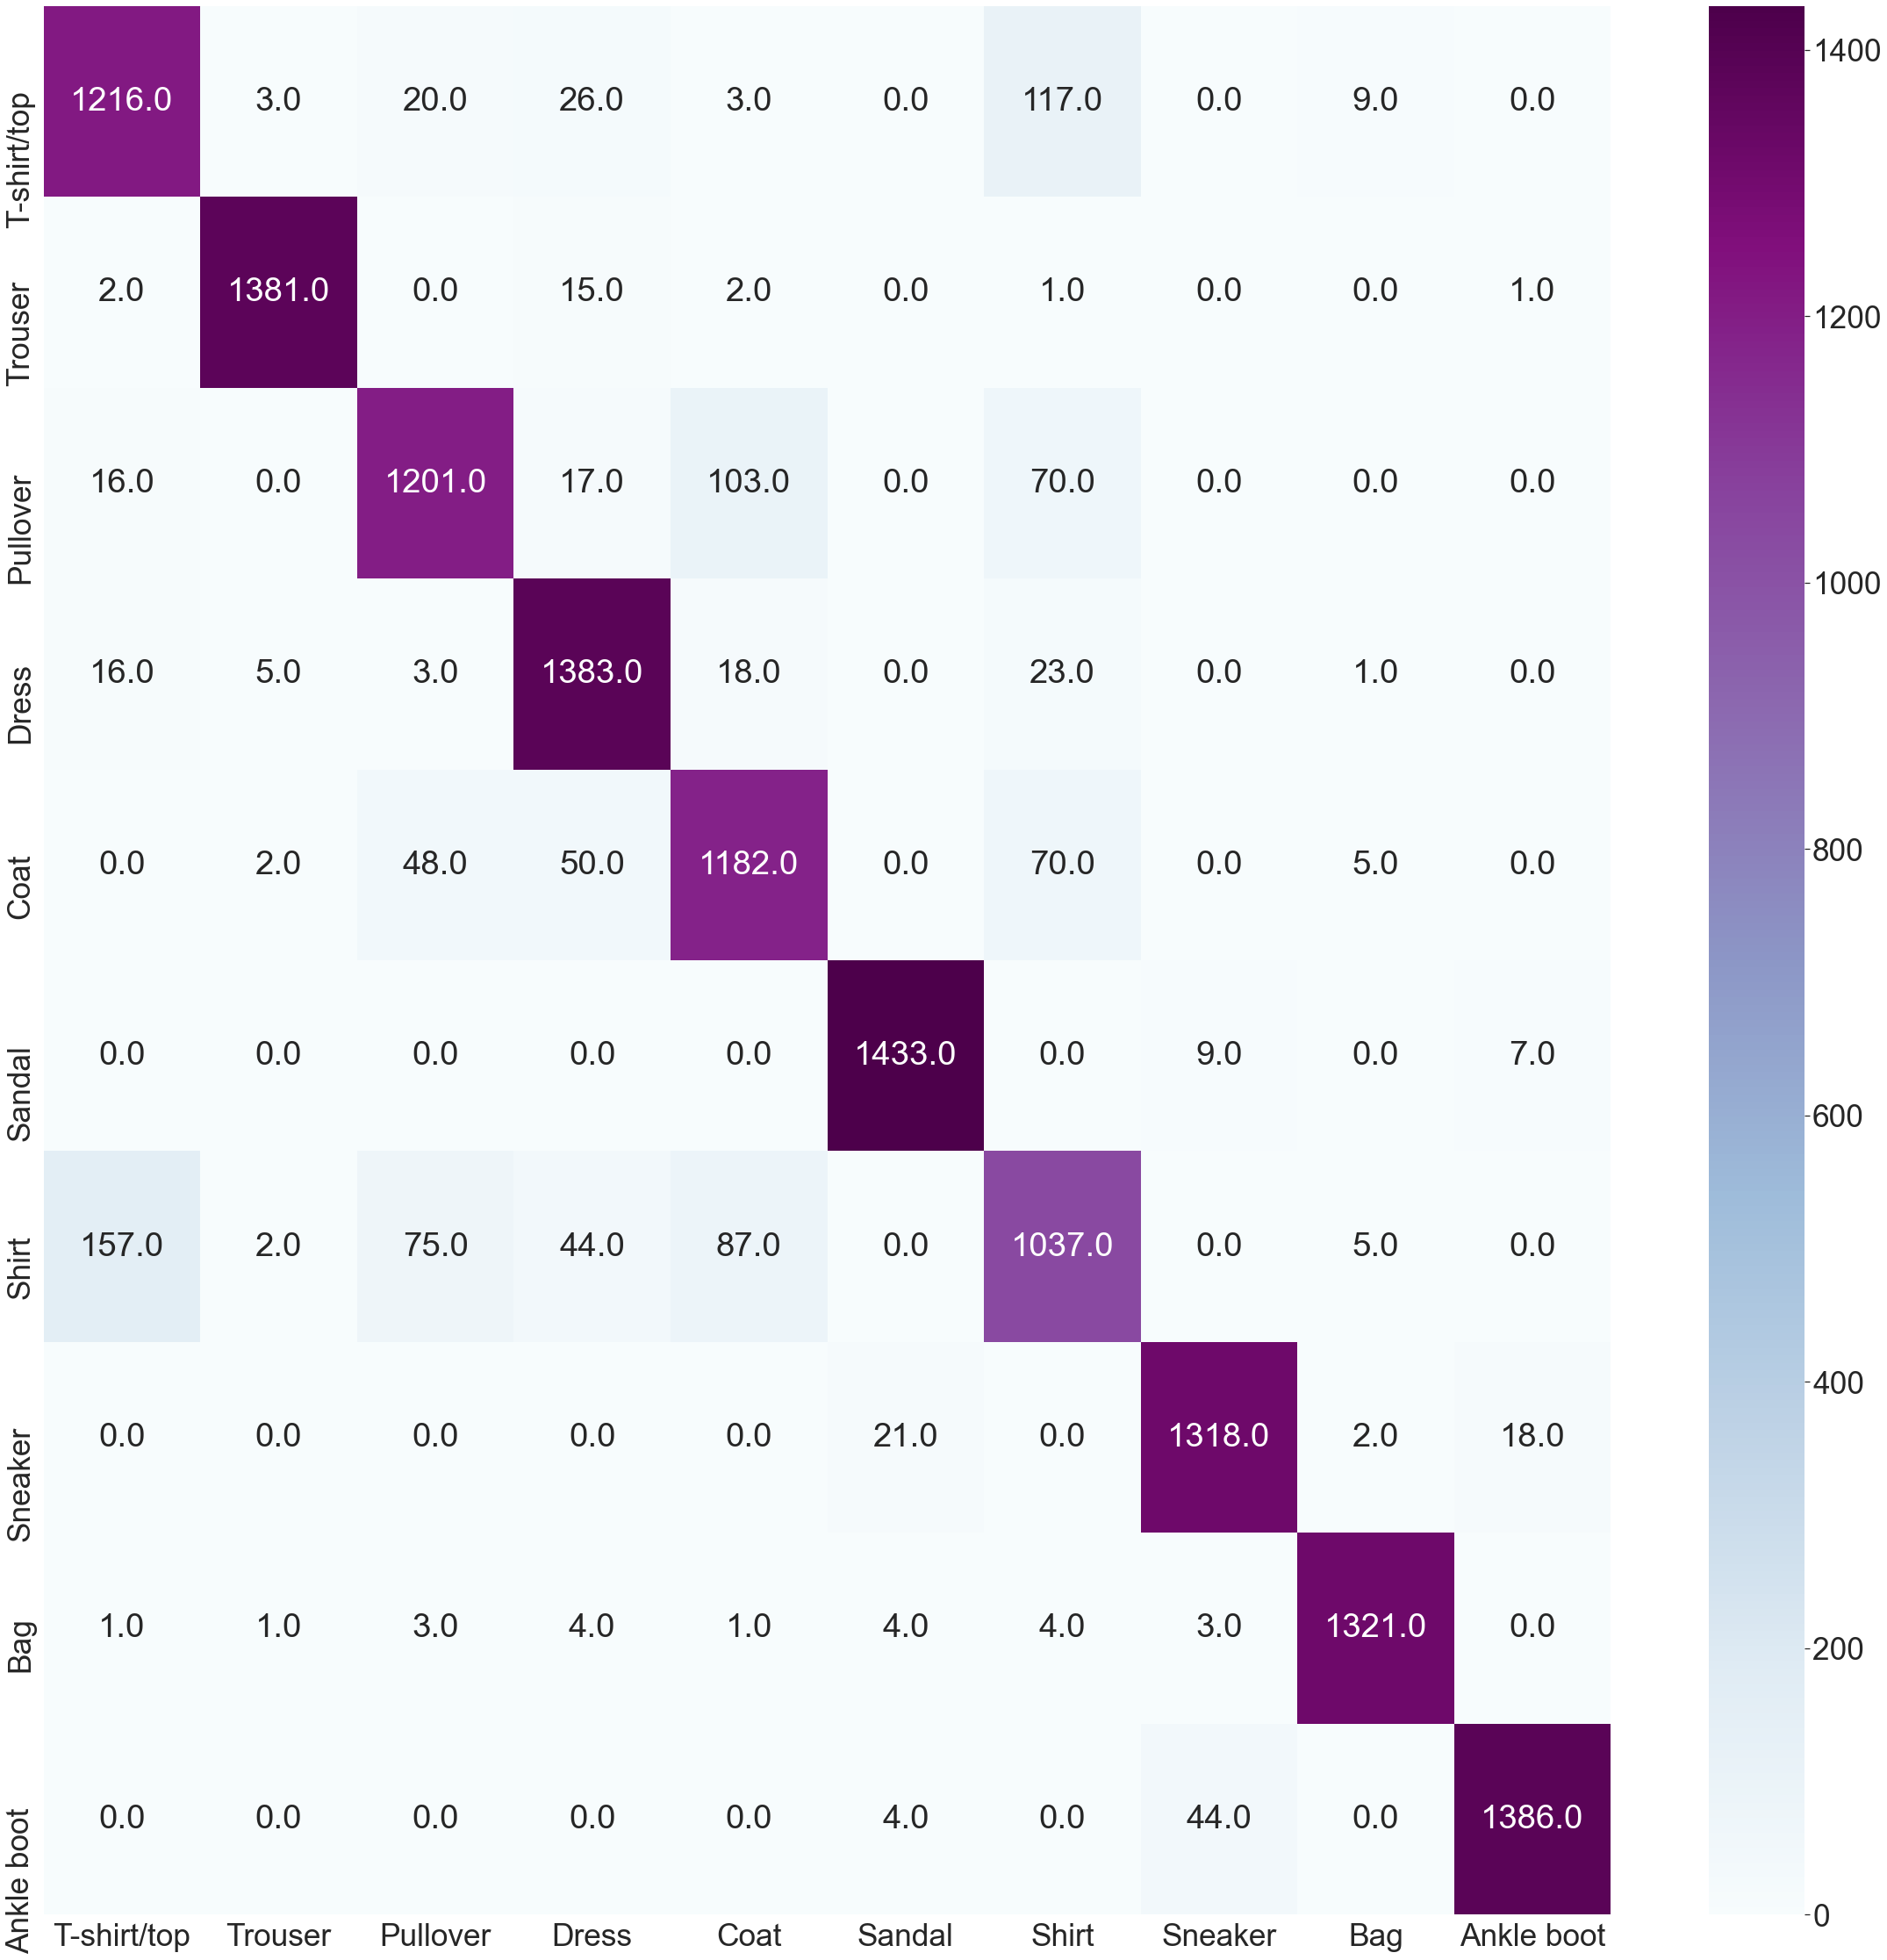

In [38]:
plt.figure(figsize=(40,40))
sns.set(font_scale = 3.2)
sns.heatmap(confusion_df,annot=True,fmt='.1f', cmap="BuPu")
plt.show()

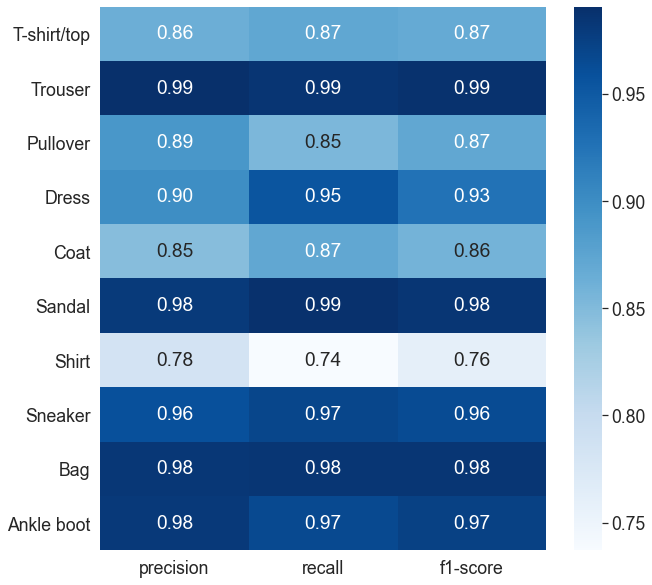

In [39]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1.6)
sns.heatmap(class_report,annot=True,fmt='.2f', cmap="Blues")
plt.show()

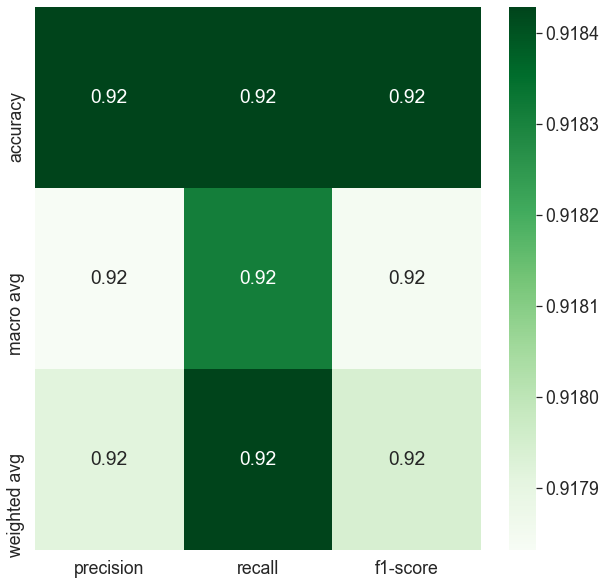

In [40]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1.6)
sns.heatmap(macro_report,annot=True,fmt='.2f', cmap="Greens")
plt.show()

<ipython-input-41-0909dfbb85c4>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


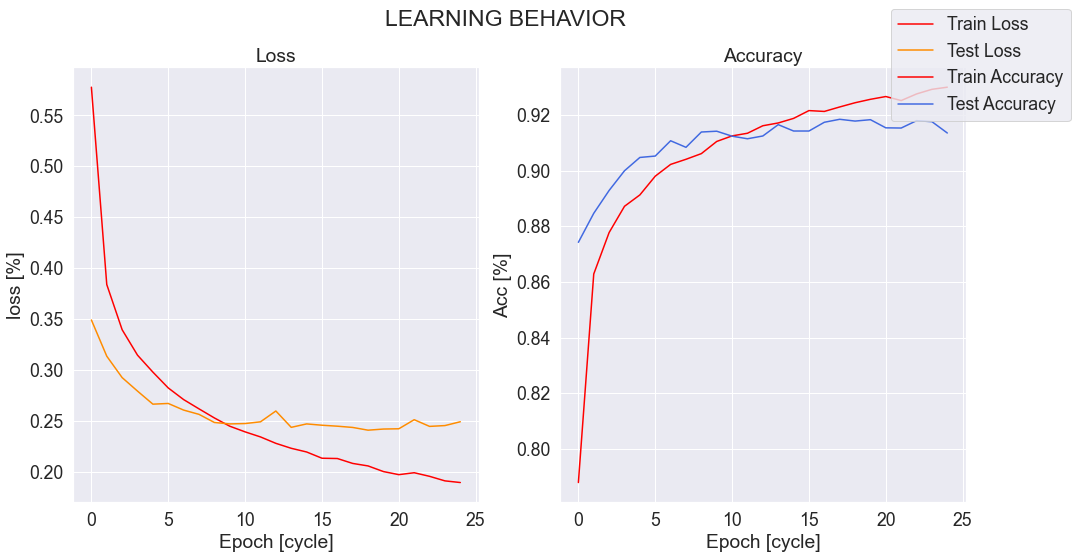

In [41]:

# reporte del aprendizaje
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

# datos de la figura en de perdida y precision
ax1.plot(cnn_log.history["loss"], 'red', label = "Train Loss")
ax1.plot(cnn_log.history["val_loss"], 'darkorange', label = "Test Loss")
ax2.plot(cnn_log.history["accuracy"], 'red', label = "Train Accuracy")
ax2.plot(cnn_log.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [42]:
# prueba funcional del autoencoder
max_img = 10
random_test_img = np.random.randint(len(X_test), size = max_img)

In [43]:
classprob_df = pd.DataFrame(columns=random_test_img, index=label_names)

for img_id in random_test_img:
    temp_cls = np.array(cnn_predictions[img_id])
    classprob_df[img_id] = temp_cls

In [44]:
middle_layer = "LayFlat"
cnn_abstraction = Model(inputs = cnn_model.input, outputs = cnn_model.get_layer(middle_layer).output)

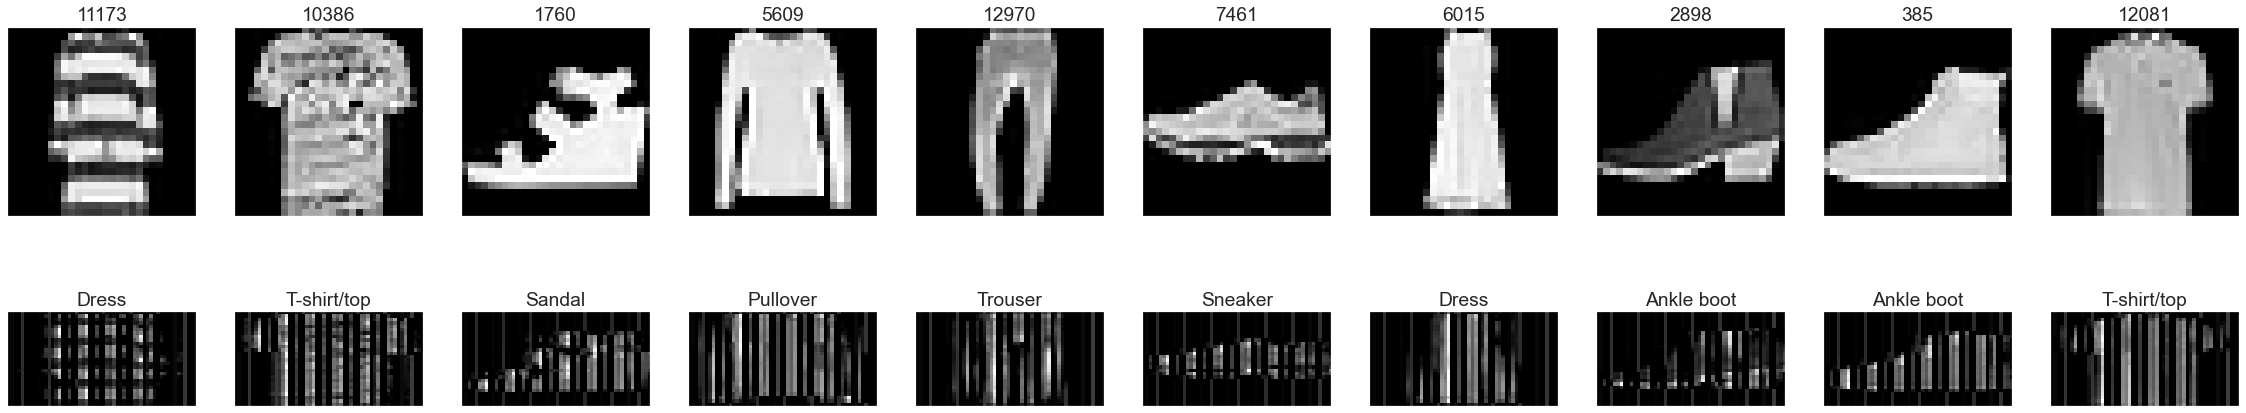

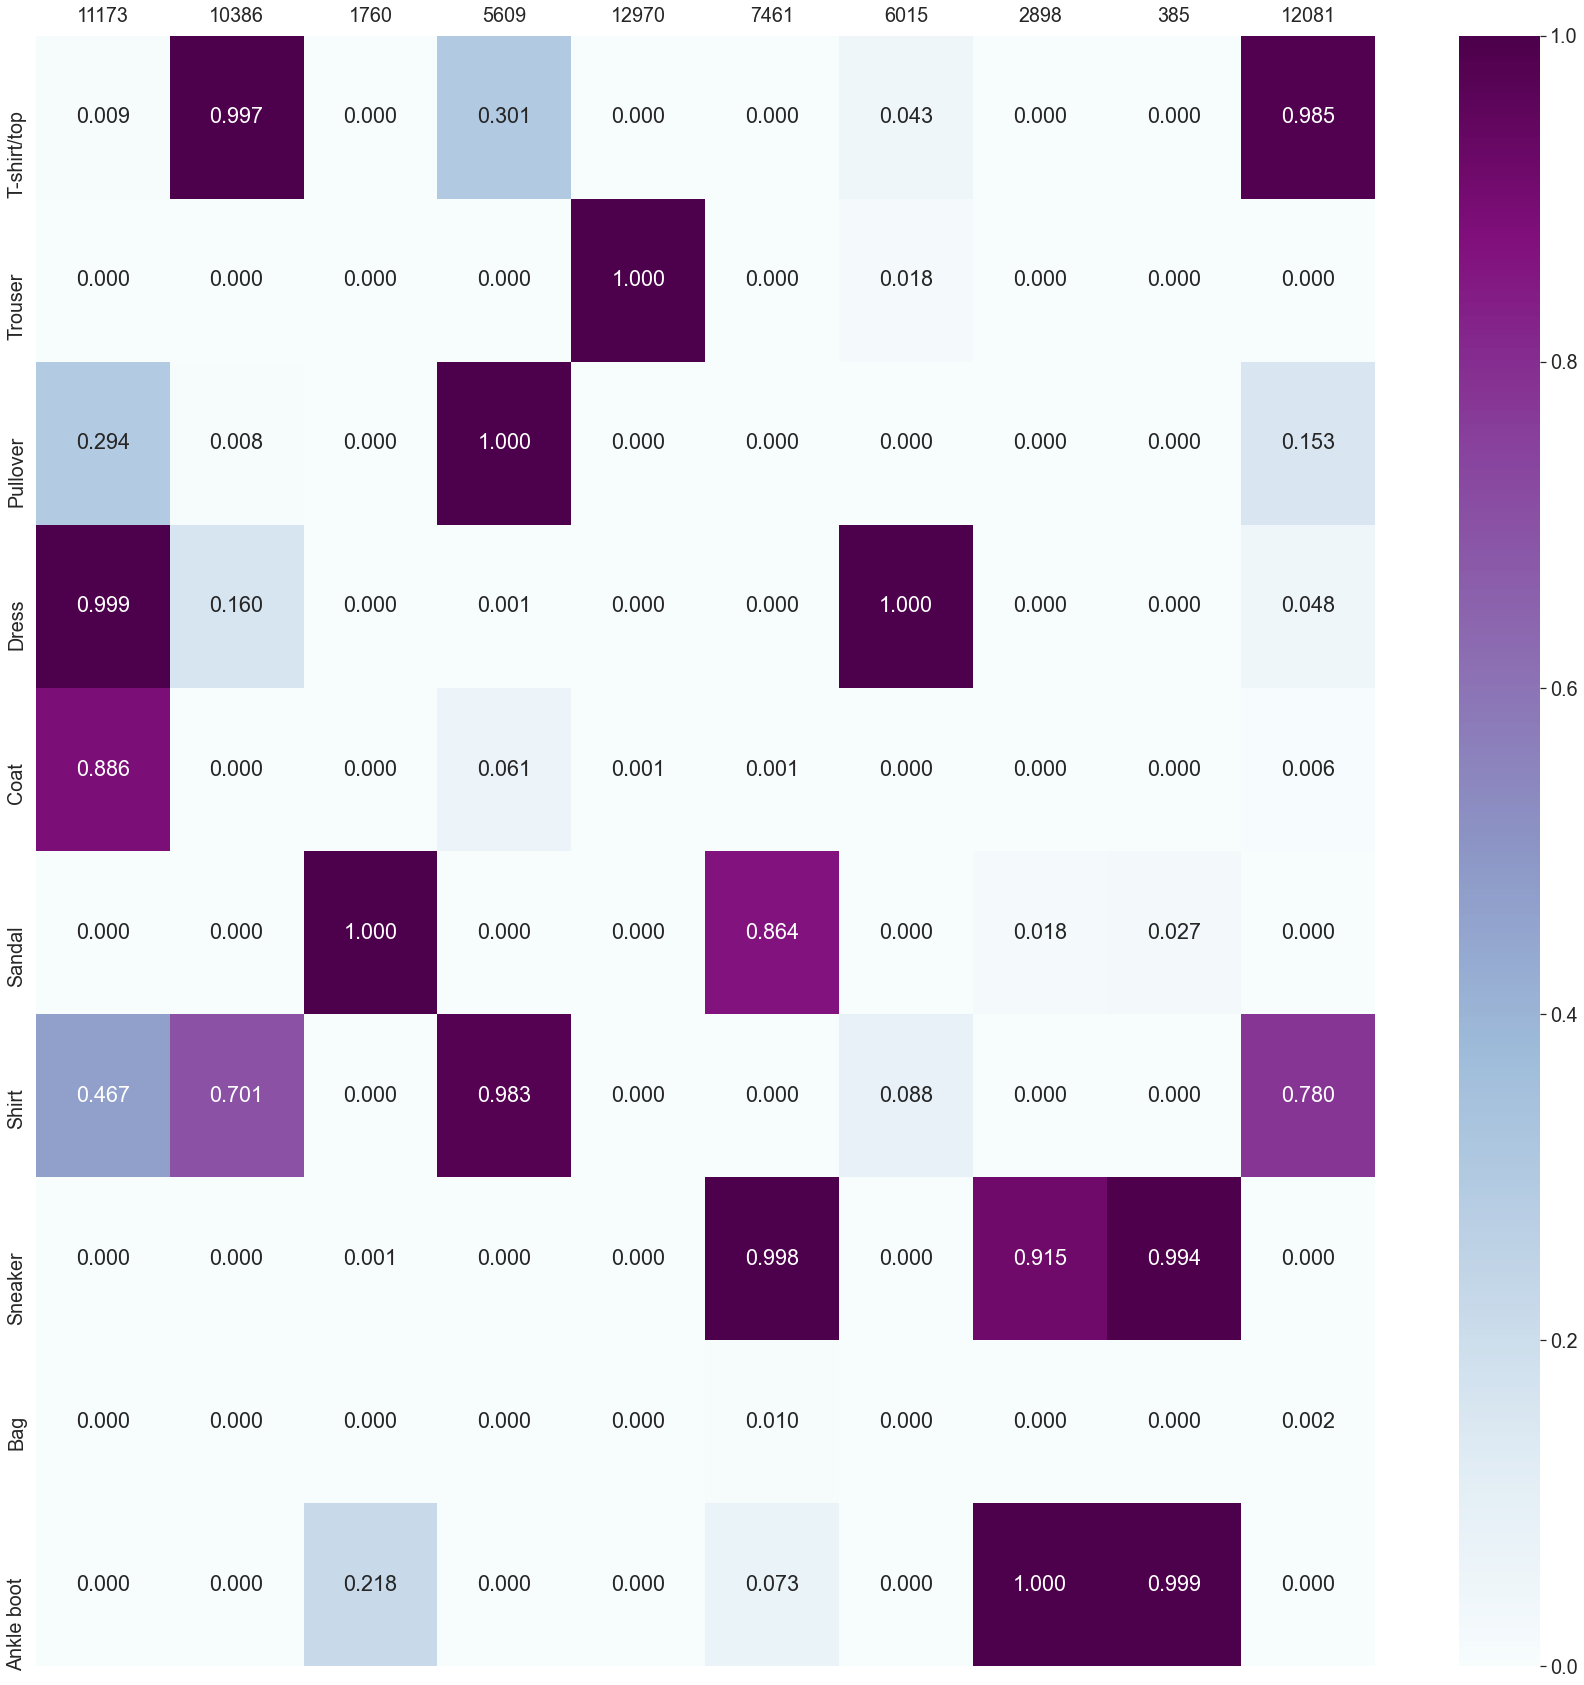

In [45]:
# desplegando pruebas
plt.figure(figsize=(40, 8))
og_shape = fashion_df[col_names[1]][0]

for i, img_id in enumerate(random_test_img):
    # imagen original
    ax = plt.subplot(2, max_img, i + 1)
    temp_X = np.array(X_test[img_id])
    plt.title(img_id)
    plt.imshow(temp_X.reshape(og_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # imagen abstracta
    ax = plt.subplot(2, max_img, max_img + i + 1)
    temp_abstract = cnn_abstraction(temp_X)
    temp_abstract = np.array(temp_abstract)

    # clasificacion aproximada
    temp_cls = np.array(cnn_predictions[img_id])
    temp_cls = temp_cls.argmax(axis=0)
    temp_cls = int(temp_cls)
    temp_cls = label_names[temp_cls]

    plt.title(temp_cls)
    plt.imshow(temp_abstract)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(30,30))
sns.set(font_scale = 1.8)
sns.heatmap(classprob_df,annot=True,fmt='.3f', cmap="BuPu")
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()